In [1]:
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import sys
import glob
import json
import numpy as np
from tqdm import tqdm
sys.path.append("../")

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import glob
import os
import pandas as pd

def get_npy_files(root_path):
    # Use a glob pattern to match all .npz files in the directory and subdirectories
    pattern = os.path.join(root_path, '**', '*.npz')
    npy_files = glob.glob(pattern, recursive=True)
    return npy_files

all_npy_files = get_npy_files("/app/dataset/npz_all/npz/layout")+get_npy_files("/app/dataset/npz_all/npz/tile/xla")
print(len(all_npy_files))
# Create a DataFrame from the list of npy files
df = pd.DataFrame(all_npy_files, columns=["path"])
print(len(df))
def find_split(x):
    if "/train" in x:
        return "train"
    elif "/valid" in x:
        return "valid"
    elif "/test" in x:
        return "test"
    return None
def find_configtype(x):
    if "/default" in x:
        return "default"
    elif "/random" in x:
        return "random"
    return "istile"
def find_modeltype(x):
    if "/nlp" in x:
        return "nlp"
    elif "/xla" in x:
        return "xla"
    return None
def find_grapthtype(x):
    if "/layout" in x:
        return "layout"
    elif "/tile" in x:
        return "tile"
    return None
df["split"] = df.path.apply(lambda x : find_split(x))
df["config_type"] = df.path.apply(lambda x : find_configtype(x))
df["modeltype"] = df.path.apply(lambda x : find_modeltype(x))
df["graphtype"] = df.path.apply(lambda x : find_grapthtype(x))
df["modelname"] = df.path.apply(lambda x: x.split("/")[-1])

7868
7868


# difference between random and default

In [3]:
import numpy as np

def histogram_equalized_sampling(data, max_configs):
    num_bins = max_configs // 2

    # Compute histogram bins and bin indices for each data point
    counts, bin_edges = np.histogram(data, bins=num_bins)
    indices = np.digitize(data, bin_edges[:-1]) - 1  # Digitize into zero-based bin indices

    # Filter out empty bins
    non_empty_bins = np.nonzero(counts)[0]
    counts = counts[non_empty_bins]

    # Calculate the number of samples to choose from each bin based on counts
    samples_per_bin = np.ceil(max_configs / len(non_empty_bins)).astype(int)

    # The array to collect the selected indices
    selected_indices = np.array([], dtype=int)

    # Sample from each non-empty bin
    for bin_idx in non_empty_bins:
        in_bin_indices = np.where(indices == bin_idx)[0]
        if len(in_bin_indices) > samples_per_bin:
            chosen_indices = np.random.choice(in_bin_indices, size=samples_per_bin, replace=False)
        else:
            chosen_indices = in_bin_indices

        selected_indices = np.concatenate([selected_indices, chosen_indices])

    # Shuffle the selected indices to avoid any potential ordering bias
    np.random.shuffle(selected_indices)

    # If we have too many indices due to ceiling operation, trim the excess
    if len(selected_indices) > max_configs:
        selected_indices = selected_indices[:max_configs]

    # If we still need more indices, we will add them from the bins with most counts
    if len(selected_indices) < max_configs:
        additional_samples_needed = max_configs - len(selected_indices)
        # Get bins sorted by the number of counts (desc) and select the top ones needed for more samples
        bins_sorted_by_count = np.argsort(-counts)
        while additional_samples_needed > 0 and len(bins_sorted_by_count) > 0:
            # Select the bin with the most samples left
            bin_for_additional_samples = bins_sorted_by_count[0]
            # Get the remaining indices from the most populous bin
            remaining_indices = np.setdiff1d(np.where(indices == bin_for_additional_samples)[0], selected_indices)
            if len(remaining_indices) == 0:
                # If the bin is exhausted, move to the next one
                bins_sorted_by_count = bins_sorted_by_count[1:]
                continue

            # Calculate how many samples to take from this bin
            samples_to_take = min(len(remaining_indices), additional_samples_needed)
            additional_indices = np.random.choice(remaining_indices, size=samples_to_take, replace=False)

            # Append these additional samples to our selected indices
            selected_indices = np.concatenate([selected_indices, additional_indices])

            # Update the number of additional samples needed
            additional_samples_needed -= samples_to_take

    return selected_indices


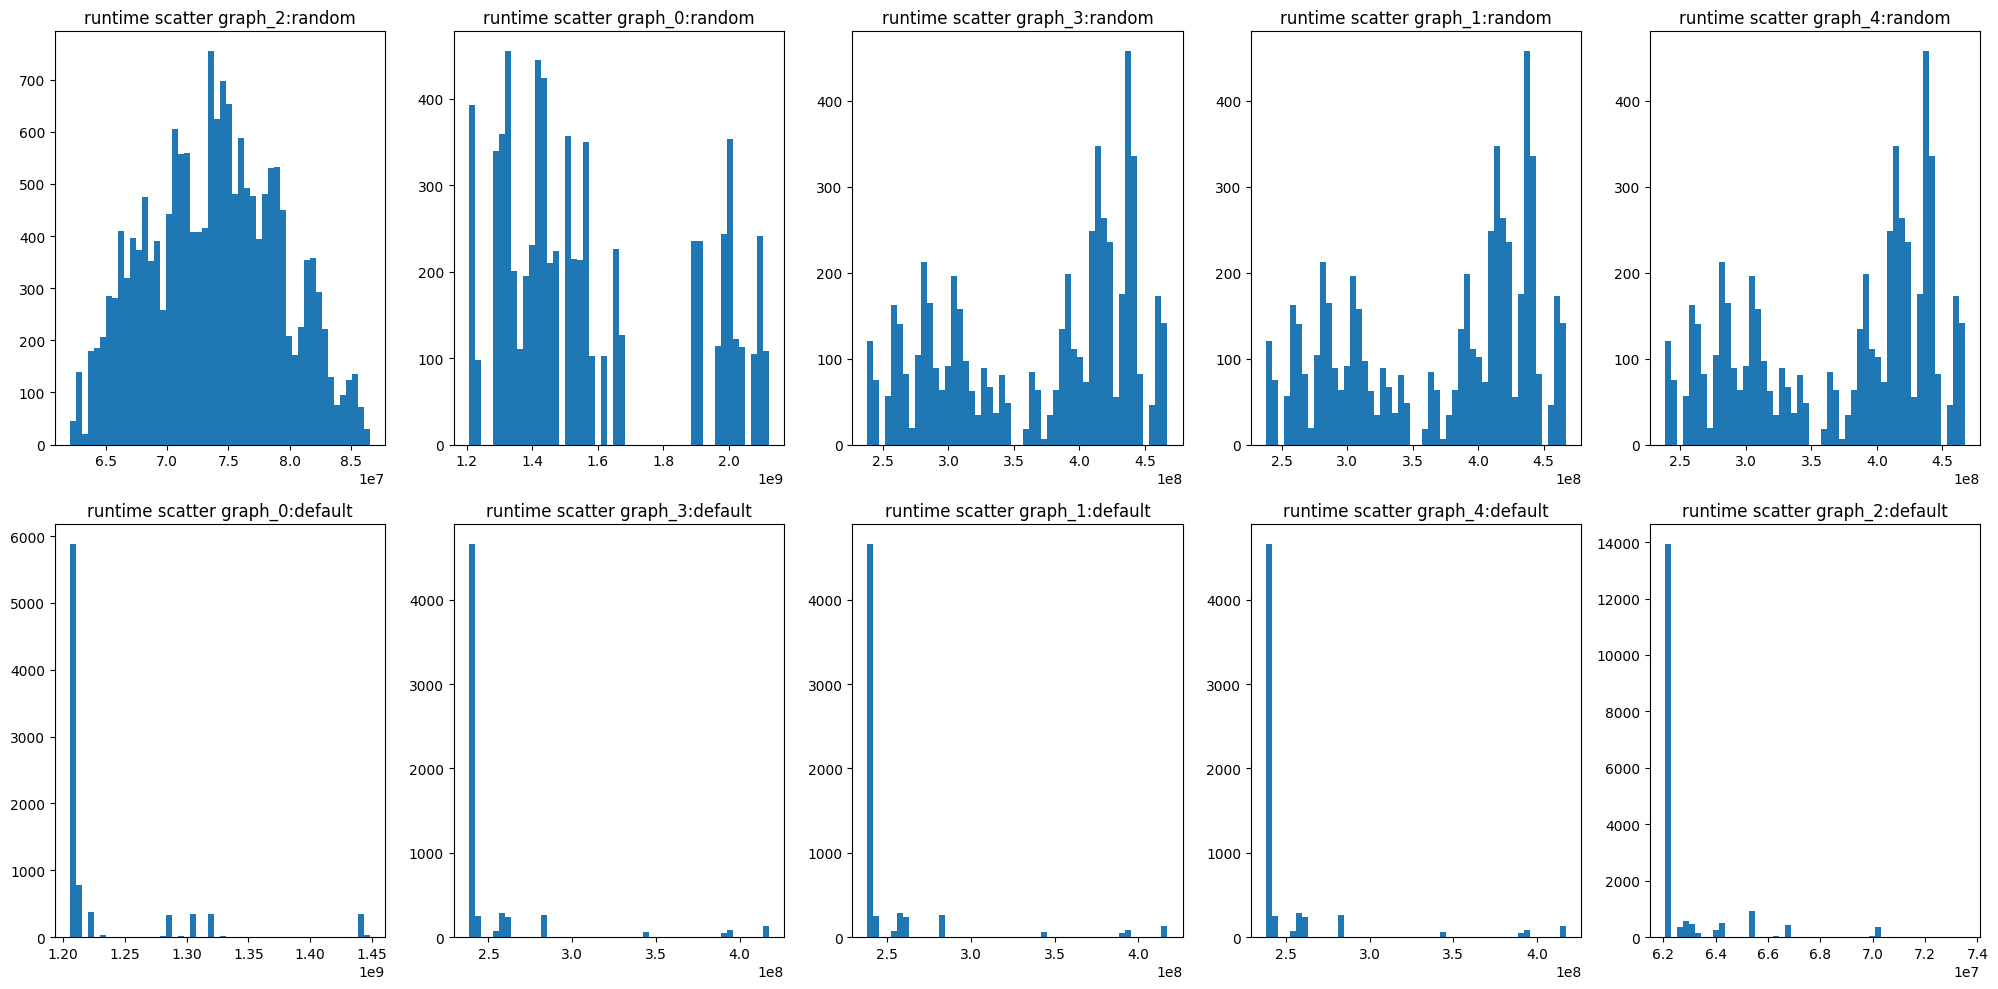

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame

# Set up the figure and axes for a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns

# Initialize a counter for the subplot index
subplot_idx = 0

for gidx in range(5):
    mname = df[(df.modeltype == "xla") & (df.graphtype == "layout") & (df.split == "valid")].modelname.sample(1).to_list()[0]
    pths = df[(df.modeltype == "xla") & (df.graphtype == "layout") & (df.split == "valid") & (df.modelname == mname)].path.to_list()
    conftype = df[(df.modeltype == "xla") & (df.graphtype == "layout") & (df.split == "valid") & (df.modelname == mname)].config_type.to_list()

    if len(pths) == 2:
        for i, (p, ct) in enumerate(zip(pths, conftype)):
            info = dict(np.load(p))
            y = info["config_runtime"]

            # Determine the row and column index for the current subplot
            row_idx = 0 if ct=="random" else 1
            col_idx = subplot_idx % 5

            axs[row_idx, col_idx].hist(y, bins=50)
            axs[row_idx, col_idx].set_title(f"runtime scatter graph_{gidx}:{ct}")

            # Increment the subplot index
            subplot_idx += 1

# Adjust the layout
plt.tight_layout()
plt.show()


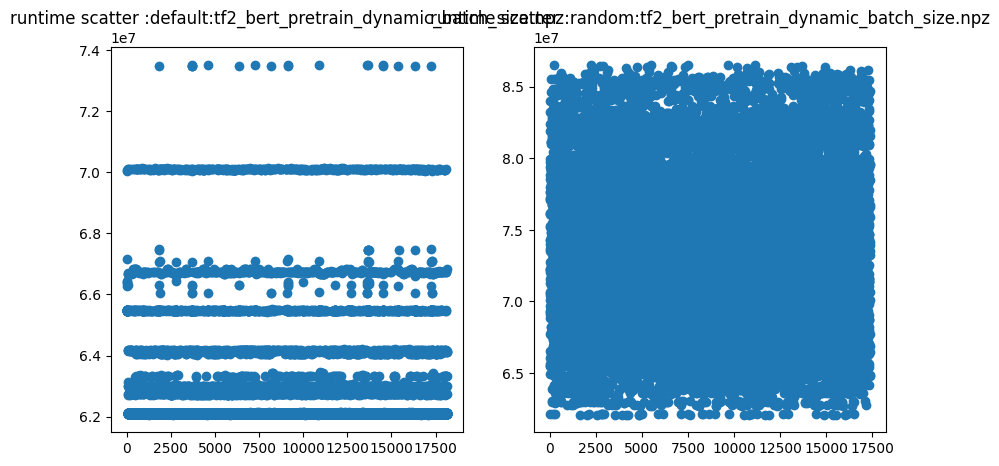

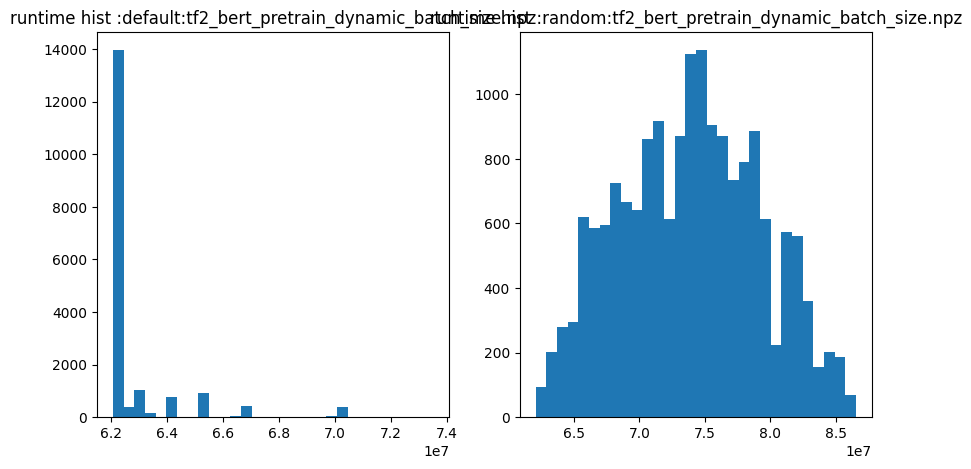

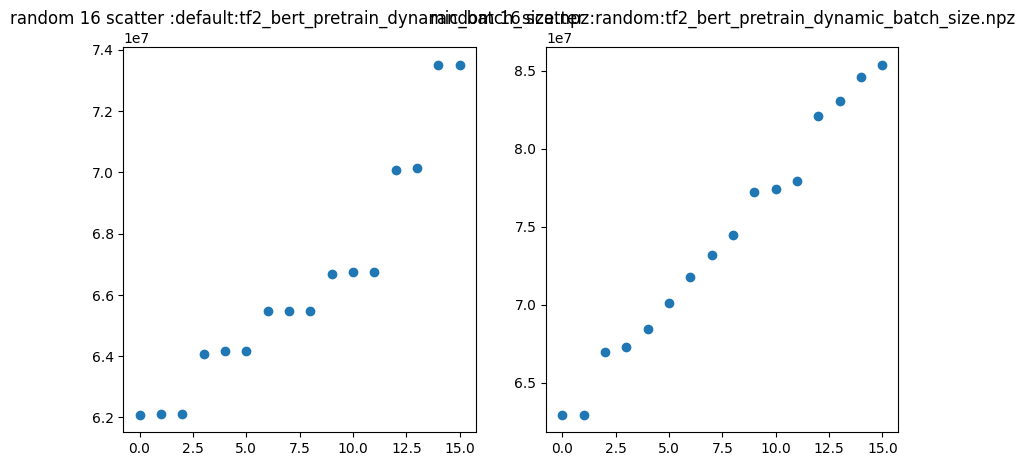

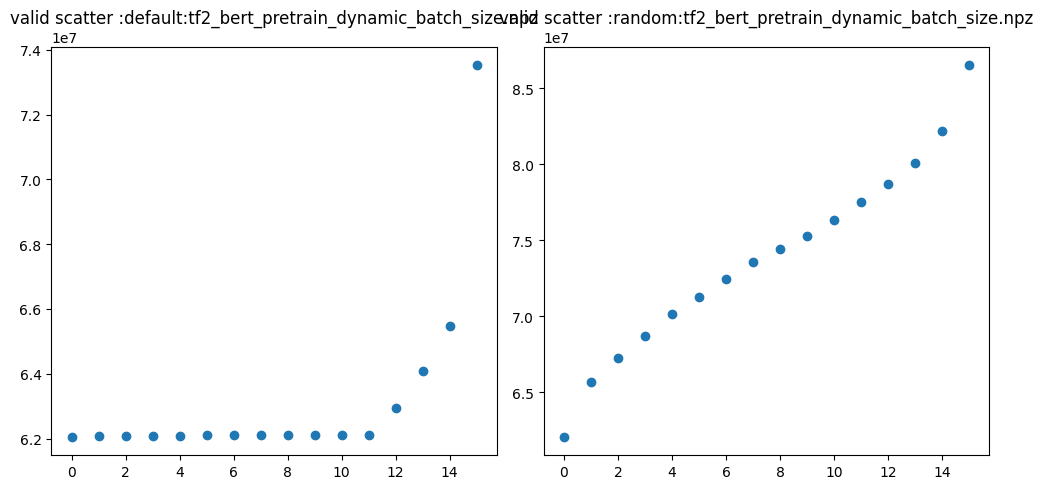

In [4]:
mname = df[(df.modeltype=="xla")&(df.graphtype=="layout")&(df.split=="valid")].modelname.sample(1).to_list()[0]
pths = df[(df.modeltype=="xla")&(df.graphtype=="layout")&(df.split=="valid")&(df.modelname==mname)].path.to_list()
conftype = df[(df.modeltype=="xla")&(df.graphtype=="layout")&(df.split=="valid")&(df.modelname==mname)].config_type.to_list()
if len(pths)==2:
    fig, axs = plt.subplots(1, 2,figsize=(10, 5)) # 1 row, 2 columns
    fig1, axs1 = plt.subplots(1, 2,figsize=(10, 5)) # 1 row, 2 columns
    fig2, axs2 = plt.subplots(1, 2,figsize=(10, 5)) # 1 row, 2 columns
    fig3, axs3 = plt.subplots(1, 2,figsize=(10, 5)) # 1 row, 2 columns
    for i,(p,ct) in enumerate(zip(pths,conftype)):
        info = dict(np.load(p))

        x = np.arange(len(info["config_runtime"]))
        y = info["config_runtime"]
        axs[i].scatter(x,y)
        axs[i].set_title(f"runtime scatter :{ct}:{mname}")
        # Second plot
        axs1[i].hist(y,bins=30)
        axs1[i].set_title(f"runtime hist :{ct}:{mname}")

        axs2[i].scatter(np.arange(16),np.sort(y[histogram_equalized_sampling(y, 16)]))
        axs2[i].set_title(f"random 16 scatter :{ct}:{mname}")

        sorted_times = np.argsort(y)
        indices = np.linspace(0, len(sorted_times) - 1, 16, dtype=int)
        axs3[i].scatter(np.arange(16),y[sorted_times[indices]])
        axs3[i].set_title(f"valid scatter :{ct}:{mname}")

    plt.tight_layout() # Adjust the layout so the plots are nicely fit
    plt.show


In [3]:
opcodes = json.load(open("/app/nn-runtime-network/assets/opt_code.json"))
feat_names = {int(k):v for i,(k,v) in enumerate(json.load(open("/app/nn-runtime-network/assets/node_feature_vector.json")).items())}


In [4]:
z = np.concatenate([np.load(d)["node_opcode"] for d in tqdm(glob.glob("/app/dataset/various_splits/all_layout/train/*"))])
uniques_train = np.unique(z,return_counts=True)

100%|██████████| 535/535 [00:00<00:00, 2533.24it/s]


In [14]:
z = np.concatenate([np.load(d)["node_opcode"] for d in tqdm(glob.glob("/app/dataset/various_splits/all_layout/valid/*"))])
uniques_val = np.unique(z,return_counts=True)

100%|██████████| 54/54 [00:00<00:00, 1927.23it/s]


In [7]:
files = np.random.choice(glob.glob("/app/dataset/various_splits/all_layout/train/*"),5)
# files = glob.glob("/app/dataset/various_splits/all_layout/test/*")


In [8]:
data = []
for d in tqdm(files):
    data.append(dict(np.load(d)))

100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


In [8]:
node_feats = np.concatenate([d["node_feat"] for d in data],0)
config_feats = np.concatenate([d["node_config_feat"].reshape(-1,18) for d in data],0)

In [38]:
def get_unique(array):
    total = array[:,0]
    for i in range(1,array.shape[1]):
        total = total+ (10**i)* array[:,i]
    return total
unique = get_unique(config_feats[:,:6])
unique = np.unique(unique)


In [40]:
unique.shape

(70,)

In [ ]:
nodefeat_names = json.load(open("/app/nn-runtime-network/assets/node_feature_vector.json"))
for i in tqdm(range(140)):
    nodefeat_names[str(i)] = np.unique(node_feats[:,i],axis=0)

In [ ]:
CATEGORICAL = [k for k,v in nodefeat_names.items() if len(v)<5]
CONTINUOUS = [k for k,v in nodefeat_names.items() if k not in CATEGORICAL]

In [ ]:
info = nodefeat_names[CONTINUOUS[11]]
plt.scatter(np.arange(len(info)),info)

In [ ]:
plt.hist([len(s["config_runtime"]) for s in data],bins=50)
plt.title(f"Histogram of number of configs")
plt.show()

In [ ]:
runtimes = [d["config_runtime"] for d in data]

In [ ]:
# Sample 8 of them
sampled_runtimes = np.random.choice(np.arange(len(runtimes)), 8, replace=False)

# Create a grid of scatter plots
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for ax, runtime in zip(axes.ravel(), sampled_runtimes):
    # Assuming runtimes are 1D arrays, we scatter them against their indices
    ax.scatter(range(len(runtimes[runtime])), runtimes[runtime])
    ax.set_xlabel("Index")
    ax.set_ylabel("Runtime Value")

plt.tight_layout()
plt.show()


In [10]:
nodeops_with_configs = np.concatenate([d["node_opcode"][d["node_config_ids"]] for d in data])

In [ ]:
number_nodes = [d["node_opcode"].shape[0] for d in data]


In [ ]:
plt.scatter(np.arange(len(number_nodes)),number_nodes)
plt.title("Number of nodes in a graph")

['convolution', 'dot', 'reshape'] [26 34 75]


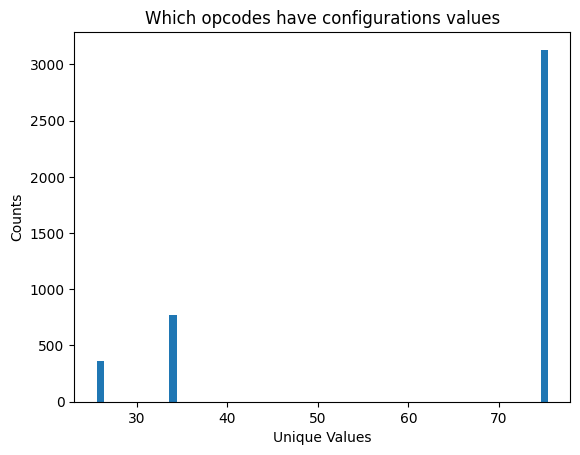

In [11]:
# Count unique values
unique_values, counts = np.unique(nodeops_with_configs, return_counts=True)
print([opcodes[str(i)] for i in unique_values],unique_values)
# Plot bar plot
plt.bar(unique_values, counts)
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.title('Which opcodes have configurations values')
plt.show()

In [ ]:
unique_values

In [ ]:
# Count unique values
unique_values, counts = np.unique(np.concatenate([d["node_opcode"] for d in data]), return_counts=True)
print(len(unique_values),[opcodes[str(i)] for i in unique_values],unique_values)
# Plot bar plot
plt.bar(unique_values, counts)
plt.xlabel('Unique Values')
plt.ylabel('Counts')
plt.title('Which opcodes have configurations values')
plt.show()

In [ ]:
import networkx as nx
import numpy as np

def graph_stats(edges_array):
    # Create a directed graph from the edges array
    G = nx.from_edgelist(edges_array, create_using=nx.DiGraph())
    
    # Calculate maximum in-degree
    in_degrees = dict(G.in_degree())
    max_in_degree = max(in_degrees.values()) if in_degrees else 0
    average_in_degree = np.mean(list(in_degrees.values())) if in_degrees else 0
    median_in_degree = np.median(list(in_degrees.values())) if in_degrees else 0


    # Calculate maximum out-degree
    out_degrees = dict(G.out_degree())
    max_out_degree = max(out_degrees.values()) if out_degrees else 0
    average_out_degree = np.mean(list(out_degrees.values())) if in_degrees else 0
    median_out_degree = np.median(list(out_degrees.values())) if in_degrees else 0

    # Calculate number of strongly connected components
    G = nx.from_edgelist(edges_array, create_using=nx.Graph())
    # (For directed graphs, we should consider strongly connected components)
    num_connected_components = len(list(nx.connected_components(G)))

    return {
        "max_in_degree": max_in_degree,
        "max_out_degree": max_out_degree,
        "average_in_degree": average_in_degree,
        "average_out_degree": average_out_degree,
        "median_in_degree": median_in_degree,
        "median_out_degree": median_out_degree,
        "num_connected_components": num_connected_components
    }

In [ ]:
stats = [graph_stats(d["edge_index"]) for d in tqdm(data)] 

In [ ]:
for k in stats[0]:
    plt.hist([s[k] for s in stats],bins=50)
    plt.title(f"Histogram of {k}")
    plt.show()

In [ ]:
import networkx as nx
import numpy as np

def connected_nodes_count(edges_array, sample_nodes_array,successor=False):
    # Create a directed graph from the edges array
    G = nx.from_edgelist(edges_array, create_using=nx.DiGraph())
    
    connected_nodes = set()
    
    for node in sample_nodes_array:
        # Add predecessors (incoming edges)
        connected_nodes.add(node.item())
        connected_nodes.update(G.predecessors(node))
        # Add successors (outgoing edges)
        if successor:
            connected_nodes.update(G.successors(node))

    # Remove sample nodes from the count, as we only want nodes connected to them
    # connected_nodes = connected_nodes - set(sample_nodes_array)

    return len(connected_nodes)

predecessor_nodes_ratio = [connected_nodes_count(d["edge_index"],d["node_config_ids"])/len(d["node_opcode"]) for d in tqdm(data)] 
direct_nodes_ratio = [connected_nodes_count(d["edge_index"],d["node_config_ids"],successor=True)/len(d["node_opcode"]) for d in tqdm(data)] 


In [ ]:
plt.hist(predecessor_nodes_ratio,bins=50)
plt.title("Histogram of ratio of predeceesors connected directly to config nodes")
plt.show()


plt.hist(direct_nodes_ratio,bins=50)
plt.title("Histogram of ratio of nodes connected directly to config nodes")
plt.show()